## Source and citation

- This notebook is part of the `pytheos` package ([Github]()). 

- __[Citation]__ S.-H. Shim (2017) Pytheos - python equations of state tools. doi:

In [3]:
%matplotlib inline
# %matplotlib notebook # for interactive

For high dpi displays.

In [4]:
%config InlineBackend.figure_format = 'retina' 

# 0. General note

- Through high pressure experiments, we can measure the molar volume of minerals at high pressure.  The data can be then fit to static equations of state, in order to obtain bulk modulus $(K_0)$ and pressure derivative of bulk modulus $(K'_0)$.  

- `pytheos` uses `lmfit` to provide equation of state fitting for static compression data.  It has a few convenient features for the flexibility, such as fixing/varying particular parameters, propagating uncertainties, etc.  This notebook shows a few examples.

# 1. Global setup

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pytheos as eos

# 2. Setup fitting models

Using MgO, we create models for three equations for static EOS.  Volume can be either in unit-cell volume or molar volume.  But `v` and `v0` should be in the same unit.

In [8]:
v0 = 11.244; k0 = 160.; k0p = 4.0

Three different equations for static EOS of MgO.

In [9]:
exp_bm3 = eos.BM3Model()
exp_vinet = eos.VinetModel()
exp_kunc = eos.KuncModel(order=5) # this way I can handle order

Assign initial values to the parameters.

In [10]:
params = exp_bm3.make_params(v0=v0, k0=k0, k0p=k0p)

# 3. Synthesize data

We make data with random noise.

In [12]:
v_data = v0 * np.linspace(0.99,0.6,20)

Calculate pressures from three different equations.

In [13]:
p_bm3 = exp_bm3.eval(params, v=v_data)
p_vinet = exp_vinet.eval(params, v=v_data)
p_kunc = exp_kunc.eval(params, v=v_data)

Create random noise (`noise`) and add it to pressure value to simulate the data.

In [17]:
sp = np.random.normal(0.,2.,20)
p_data = p_bm3 + sp

Plot the synthetic data together with true values.

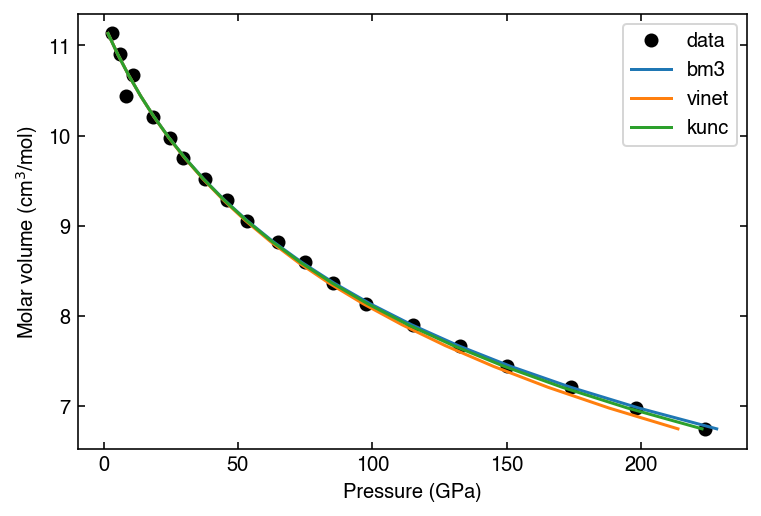

In [19]:
plt.plot(p_data, v_data, 'ko', label='data')
plt.plot(p_bm3, v_data, label='bm3')
plt.plot(p_vinet, v_data, label='vinet')
plt.plot(p_kunc, v_data, label='kunc')
plt.xlabel('Pressure (GPa)'); plt.ylabel('Molar volume (cm$^3$/mol)')
plt.legend();

The cell below shows the systematic differences between the equations.

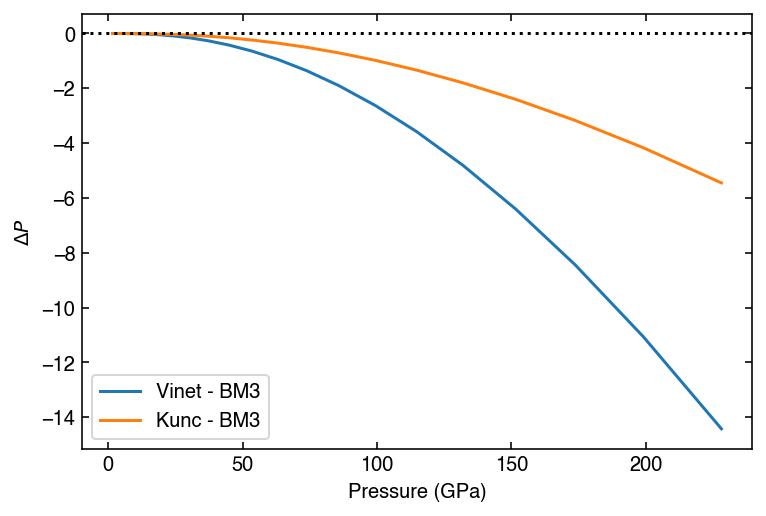

In [21]:
plt.plot(p_bm3, p_vinet-p_bm3, label='Vinet - BM3')
plt.plot(p_bm3, p_kunc-p_bm3, label='Kunc - BM3')
plt.xlabel('Pressure (GPa)'); plt.ylabel('$\Delta P$')
plt.axhline(0, c='k', ls=':')
plt.legend();

# 4. EOS fitting

We fix $V_0$ as it is typically well known.  We can also fix any parameters in `lmfit`.

In [22]:
params['v0'].vary = False
#params['k0'].vary = False

It is common practice not to include weight for the $P$-$V$ fit because it will de-emphasize the high pressure data points.  But if you need, you can set weight in the following way.  `None` performs unweighted fitting

In [27]:
weight = None # 1./sp#None

The cell below performs fitting with BM3 equation.

In [29]:
fitresult_bm3 = exp_bm3.fit(p_data, params, v=v_data, weights=weight)

You may print out the fitting result.

In [31]:
print(fitresult_bm3.fit_report())

[[Model]]
    Model(bm3_p)
[[Variables]]
    v0:    11.244 (fixed)
    k0:    162.983967 +/- 2.675975 (1.64%) (init= 160)
    k0p:   3.90210730 +/- 0.063504 (1.63%) (init= 4)
[[Correlations]] (unreported correlations are <  0.100)
    C(k0, k0p)                   = -0.973 



Fitting can be performed for other equations.

In [32]:
fitresult_vinet = exp_vinet.fit(p_data, params, v=v_data, weights=weight)
print(fitresult_vinet.fit_report())

[[Model]]
    Model(vinet_p)
[[Variables]]
    v0:    11.244 (fixed)
    k0:    157.884662 +/- 2.962237 (1.88%) (init= 160)
    k0p:   4.27648403 +/- 0.093778 (2.19%) (init= 4)
[[Correlations]] (unreported correlations are <  0.100)
    C(k0, k0p)                   = -0.981 



In [33]:
fitresult_kunc = exp_kunc.fit(p_data, params, v=v_data, weights=weight)
print(fitresult_kunc.fit_report())

[[Model]]
    Model(kunc_p, order='5')
[[Variables]]
    v0:    11.244 (fixed)
    k0:    161.356522 +/- 3.077006 (1.91%) (init= 160)
    k0p:   4.01543843 +/- 0.095308 (2.37%) (init= 4)
[[Correlations]] (unreported correlations are <  0.100)
    C(k0, k0p)                   = -0.981 



# 5. Play with the results

The example below shows how to get individual parameters from the fitting result.

In [34]:
fitresult_vinet.params['k0p'].value

4.276484030702715

You can also get estimated uncertainties.

In [35]:
fitresult_vinet.params['k0p'].stderr

0.093778811799291553

The cells below show how to calculate fitted pressure values at the data points.  First, we get the fit parameters.

In [37]:
v0_r = fitresult_vinet.params['v0']
k0_r = fitresult_vinet.params['k0']
k0p_r = fitresult_vinet.params['k0p']

Then we get the function used for the fitting.

In [38]:
f = fitresult_vinet.model

`eval` conducts calculation for given volume value.

In [39]:
f.eval(params, v=v_data)

array([   1.64066312,    5.27636535,    9.30448249,   13.76766015,
         18.71382605,   24.19695044,   30.27793358,   37.0256445 ,
         44.518141  ,   52.84410719,   62.10455355,   72.41483479,
         83.90705452,   96.73294249,  111.06731255,  127.11223733,
        145.10211304,  165.30983535,  188.05437166,  213.71009878])

In [41]:
f.func(v_data, v0, k0, k0p)

array([   1.64066312,    5.27636535,    9.30448249,   13.76766015,
         18.71382605,   24.19695044,   30.27793358,   37.0256445 ,
         44.518141  ,   52.84410719,   62.10455355,   72.41483479,
         83.90705452,   96.73294249,  111.06731255,  127.11223733,
        145.10211304,  165.30983535,  188.05437166,  213.71009878])

If you want to get array of (p, v) for plotting smooth fitting curve:

In [42]:
v_fitline = np.linspace(v0,v_data.min(),100)

In [43]:
p_fitline = f.func(v_fitline, v0_r, k0_r, k0p_r)

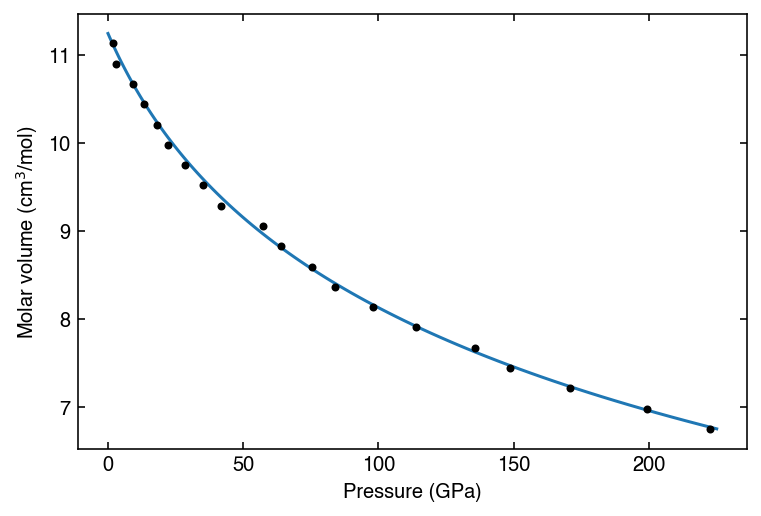

In [45]:
plt.plot(p_fitline, v_fitline)
plt.plot(p_data_bm3, v_data, 'k.', label='data')
plt.xlabel('Pressure (GPa)'); plt.ylabel('Molar volume (cm$^3$/mol)');

The cell below shows how to get the fitting results with uncertainties.

In [46]:
fitresult_bm3.params

Parameters([('v0', <Parameter 'v0', value=11.244 (fixed), bounds=[0.0:inf]>),
            ('k0',
             <Parameter 'k0', value=162.98396755963196 +/- 2.68, bounds=[0.0:inf]>),
            ('k0p',
             <Parameter 'k0p', value=3.9021073077883299 +/- 0.0635, bounds=[0.0:inf]>)])

The cell below shows how to get the uncertainties of the fit curve.

In [53]:
from uncertainties import ufloat
p_err = f.func(v_fitline, ufloat(fitresult_bm3.params['v0'].value, 0.),
         ufloat(fitresult_bm3.params['k0'].value, fitresult_bm3.params['k0'].stderr),
         ufloat(fitresult_bm3.params['k0p'].value, fitresult_bm3.params['k0p'].stderr))

The cell below shows the results in a table.  It only shows the first five data points, but `p_err` contains 100 points as we setup that way above.

In [54]:
import pandas as pd
df = pd.DataFrame()
df['p'] = p_err
df.head()

,p
0,0.0+/-0
1,0.665+/-0.011
2,1.343+/-0.022
3,2.035+/-0.033
4,2.74+/-0.05


`pytheos` has internal plot script, which takes care of the plotting the fitting results with useful information.

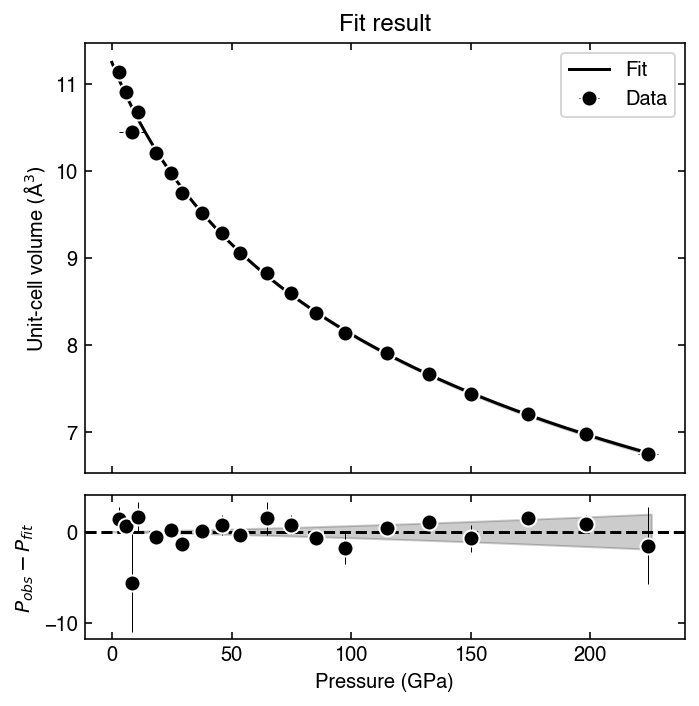

In [55]:
eos.plot.static_fit_result(fitresult_bm3, p_err=sp)

How about the fit results for the other functions?

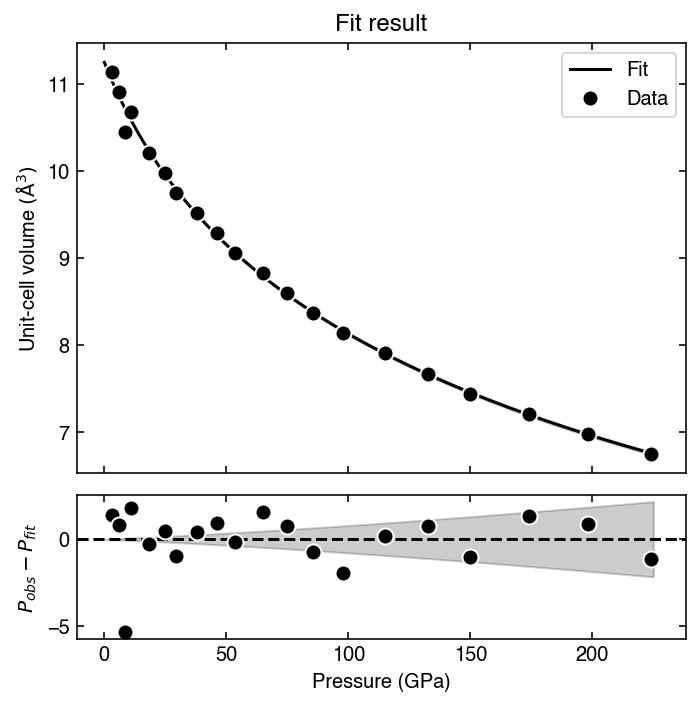

In [57]:
eos.plot.static_fit_result(fitresult_vinet)

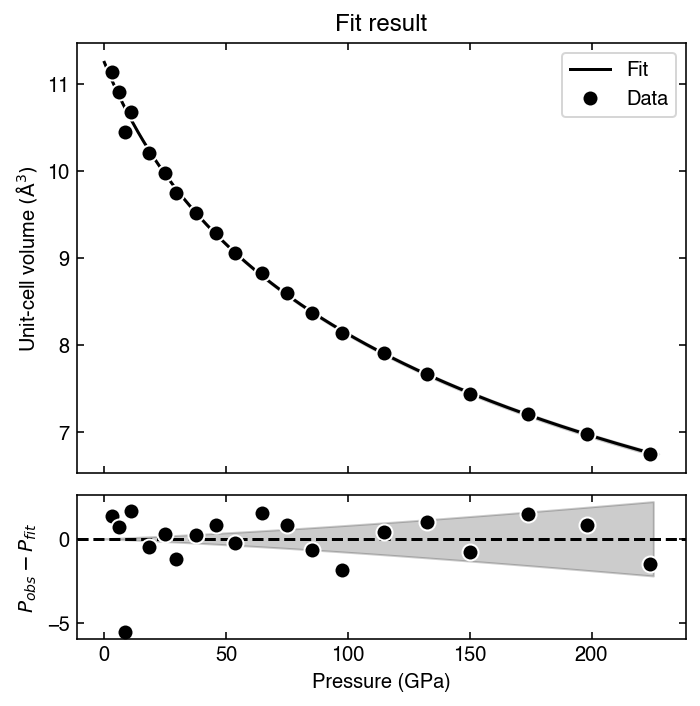

In [58]:
eos.plot.static_fit_result(fitresult_kunc)

Why the estimated uncertainty shown in the bottom parts of the figures are greater in Vinet and Kunc fittings?  It is perhaps due to the systematic differences among the equations.  Note that the synthetic data set was created from BM3 equation.